In [14]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_mnist():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    train_X = train_X.reshape(-1, 784)
    test_X = test_X.reshape(-1, 784)
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X /= 255
    test_X /= 255

    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    return {"train_X": train_X[:55000, :], "train_y": train_y[:55000, :],
            "val_X": train_X[55000:, :], "val_y": train_y[55000:, :], "test_X": test_X, "test_y": test_y}

In [3]:
def build_network(keep_prob=0.5, optimizer='adam'): #keep_prob : dropout 비율
    inputs = Input(shape=(784,), name="input")
    x = Dense(512, activation='relu', name="hidden1")(inputs)
    x = Dropout(keep_prob)(x)
    x = Dense(256, activation='relu', name="hidden2")(x)
    x = Dropout(keep_prob)(x)
    x = Dense(128, activation='relu', name="hidden3")(x)
    x = Dropout(keep_prob)(x)
    prediction = Dense(10, activation='softmax', name="output")(x)
    model = Model(inputs=inputs, outputs=prediction)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [4]:
def create_hyperparameters():
    batches = [10, 20, 30, 40, 50]
    optimizers = ['rmsprop', 'adam', 'adadelta']
    dropout = np.linspace(0.1, 0.5, 5)
    return {"batch_size": batches, "optimizer": optimizers, "keep_prob": dropout}

In [5]:
#RandomizedSearchCV?

In [5]:
data = load_mnist()
model = KerasClassifier(build_fn=build_network, verbose=0)
hyperparameters = create_hyperparameters()

search = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, n_iter=10, n_jobs=1, cv=3, verbose=1)
# n_jobs은 cpu병렬처리이고 cpu사용시 >1되어야 하며(default=None이나 1처리), GPU사용할 경우 default로 두면 된다.(1로 처리)

search.fit(data["train_X"], data["train_y"])

print(search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.0min finished


{'optimizer': 'adadelta', 'keep_prob': 0.1, 'batch_size': 10}


In [25]:
def print_model_metrics(model, data):
    #모델 평가하기(test data)
    loss, accuracy = model.evaluate(x=data["test_X"], y=data["test_y"])
    print("\n model test loss is "+str(loss)+" accuracy is "+str(accuracy))
    
    # 정밀도, 재현율, f1 값 
    y_softmax = model.predict(data["test_X"]) # batch_size=32 # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = data["test_y"].argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))
    
    # 영상입력 다중분류 모델사용하기(실제손글씨 판정결과 plt)   <======   model.add(Dense(10, activation='softmax'))
    width = 28
    height = 28
    plt_row = 5
    plt_col = 5
    plt.rcParams["figure.figsize"] = (10,10)
    f, axarr = plt.subplots(plt_row, plt_col)
    cnt = 0
    i = 0
    j = []
    while cnt < (plt_row*plt_col):
        if np.argmax(data["test_y"][i]) == np.argmax(y_softmax[i]):
            i += 1
            continue
        sub_plt = axarr[cnt//plt_row, cnt%plt_col]
        sub_plt.axis('off')
        sub_plt.imshow(data["test_X"][i].reshape(width, height))
        sub_plt_title = 'R: ' + str(np.argmax(data["test_y"][i])) + ' P: ' + str(np.argmax(y_softmax[i]))
        sub_plt.set_title(sub_plt_title)
        j.append(i)

        i += 1    
        cnt += 1

    print(f'\ntest data {len(y_softmax)}중에서 {plt_row*plt_col} 틀린 손글씨')
    print(f'틀린 index : {j}')

    plt.show()
    

In [11]:
def plt_model_process(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 0.5])
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylim([0.8, 1.0])
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='lower left')
    acc_ax.legend(loc='upper left')
    plt.show()   

In [9]:
# model 적용
data = load_mnist() #딕셔너리로 리턴 
#callbacks = create_callbacks()
model = build_network(keep_prob=0.1, optimizer='adadelta') 
hist=model.fit(x=data["train_X"], y=data["train_y"],
          batch_size=10,
          epochs=10, #50
          validation_data=(data["val_X"], data["val_y"]),
          verbose=1)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 20s 363us/step - loss: 0.2202 - accuracy: 0.9343 - val_loss: 0.0968 - val_accuracy: 0.9734
Epoch 2/10
55000/55000 [==============================] - 21s 374us/step - loss: 0.1090 - accuracy: 0.9696 - val_loss: 0.0818 - val_accuracy: 0.9792
Epoch 3/10
55000/55000 [==============================] - 19s 347us/step - loss: 0.0860 - accuracy: 0.9769 - val_loss: 0.0883 - val_accuracy: 0.9776
Epoch 4/10
55000/55000 [==============================] - 19s 338us/step - loss: 0.0761 - accuracy: 0.9809 - val_loss: 0.0914 - val_accuracy: 0.9826
Epoch 5/10
55000/55000 [==============================] - 19s 345us/step - loss: 0.0710 - accuracy: 0.9833 - val_loss: 0.0931 - val_accuracy: 0.9810
Epoch 6/10
55000/55000 [==============================] - 18s 334us/step - loss: 0.0659 - accuracy: 0.9849 - val_loss: 0.1180 - val_accuracy: 0.9790
Epoch 7/10
55000/55000 [==============================] -

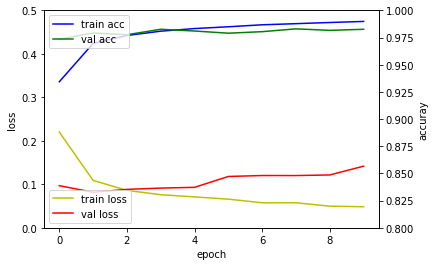

In [12]:
plt_model_process(hist)
#과적합이 나타났음, dropout

10000/10000 [==============================] - 0s 29us/step

 model test loss is 0.12345314749461632 accuracy is 0.9807000160217285
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.96      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.96      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


test data 10000중에서 25 틀린 손글씨
틀린 index : [149, 247, 274, 320, 321, 495, 582, 646, 691, 720, 844, 947, 951, 95

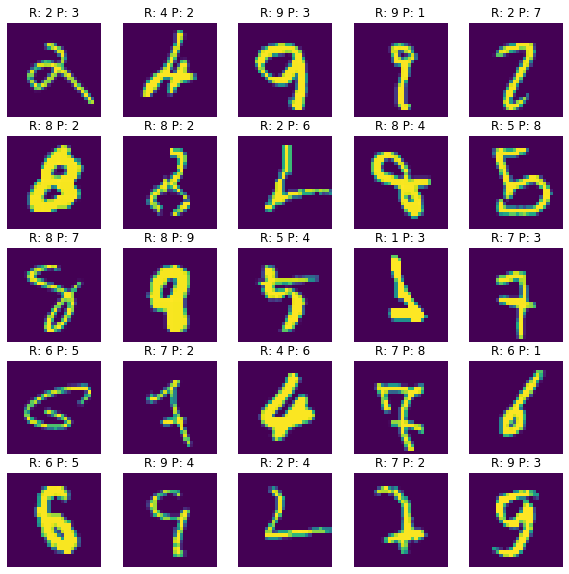

In [26]:
 print_model_metrics(model, data)

In [30]:
# model 하이퍼파라미터 변경 적용
data = load_mnist() #딕셔너리로 리턴 
model = build_network(keep_prob=0.5, optimizer='adam') 
#callbacks = create_callbacks()5, optimizer='adadelta') 
hist=model.fit(x=data["train_X"], y=data["train_y"],
          batch_size=50,
          epochs=20, #50
          validation_data=(data["val_X"], data["val_y"]),
          verbose=1)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 63us/step - loss: 0.5014 - accuracy: 0.8439 - val_loss: 0.1228 - val_accuracy: 0.9676
Epoch 2/20
55000/55000 [==============================] - 4s 76us/step - loss: 0.2363 - accuracy: 0.9349 - val_loss: 0.0956 - val_accuracy: 0.9704
Epoch 3/20
55000/55000 [==============================] - 4s 64us/step - loss: 0.1868 - accuracy: 0.9493 - val_loss: 0.0833 - val_accuracy: 0.9772
Epoch 4/20
55000/55000 [==============================] - 4s 68us/step - loss: 0.1616 - accuracy: 0.9544 - val_loss: 0.0747 - val_accuracy: 0.9774
Epoch 5/20
55000/55000 [==============================] - 4s 65us/step - loss: 0.1461 - accuracy: 0.9597 - val_loss: 0.0758 - val_accuracy: 0.9768
Epoch 6/20
55000/55000 [==============================] - 3s 58us/step - loss: 0.1340 - accuracy: 0.9628 - val_loss: 0.0795 - val_accuracy: 0.9792
Epoch 7/20
55000/55000 [==============================] - 3s 59us/ste

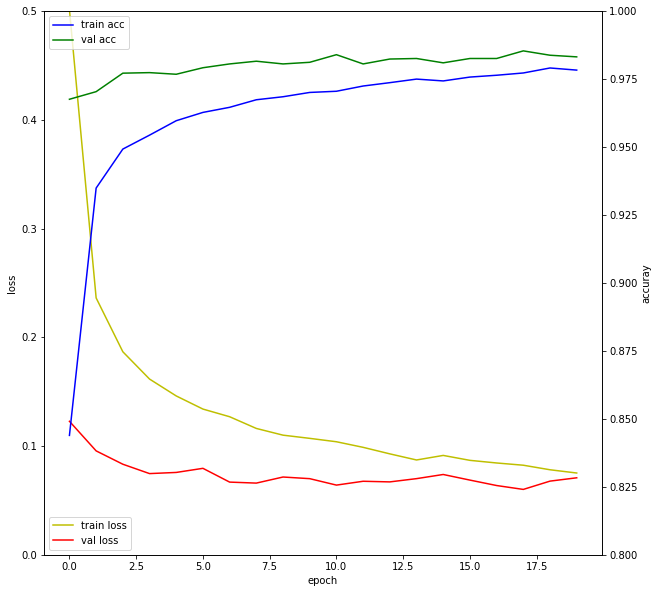

In [31]:
plt_model_process(hist)


10000/10000 [==============================] - 0s 28us/step

 model test loss is 0.07487379250939345 accuracy is 0.9817000031471252
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


test data 10000중에서 25 틀린 손글씨
틀린 index : [247, 259, 321, 340, 445, 447, 495, 582, 610, 619, 659, 684, 691, 70

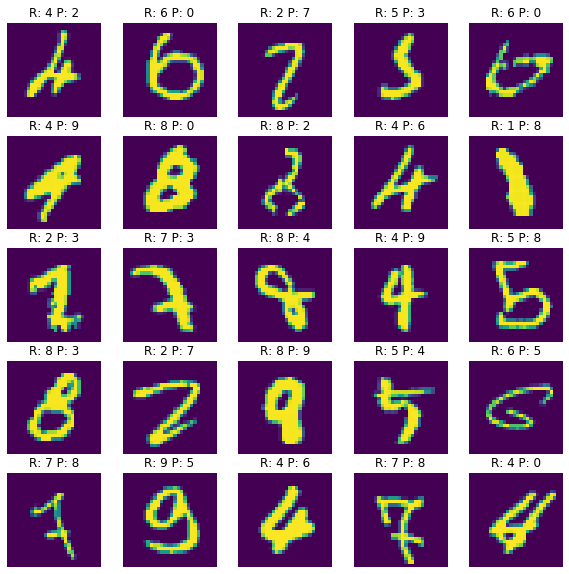

In [32]:
 print_model_metrics(model, data)